##  Setup

In [ ]:

# If running in Colab, uncomment the following line
# !pip -q install transformers==4.44.2 torch accelerate sentence-transformers sacrebleu gradio==4.44.0 datasets==2.21.0 graphviz

import os, sys, json, math, random, textwrap, pathlib
from typing import List, Dict, Tuple

import torch
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSeq2SeqLM
from datasets import Dataset
from typing import Optional

# Try sentence-transformers for retrieval
try:
    from sentence_transformers import SentenceTransformer, util
    SENTENCE_TRANSFORMERS_AVAILABLE = True
except Exception as e:
    SENTENCE_TRANSFORMERS_AVAILABLE = False
    print("sentence-transformers not available; retrieval will fall back to simple string matching.")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


##  Configuration

In [ ]:

CONFIG = {
    # QA model (baseline). You can swap this with your Task C fine-tuned checkpoint.
    "qa_model_name": "distilbert-base-cased-distilled-squad",

    # Translation model (EN->FR). Alternatives: 'Helsinki-NLP/opus-mt-en-fr'
    "mt_model_name": "Helsinki-NLP/opus-mt-en-fr",

    # Retriever
    "embedder_name": "sentence-transformers/all-MiniLM-L6-v2",  # small & fast
    "top_k_contexts": 3,
}
print(json.dumps(CONFIG, indent=2))


{
  "qa_model_name": "distilbert-base-cased-distilled-squad",
  "mt_model_name": "Helsinki-NLP/opus-mt-en-fr",
  "embedder_name": "sentence-transformers/all-MiniLM-L6-v2",
  "top_k_contexts": 3
}


In [ ]:

from dataclasses import dataclass

@dataclass
class Doc:
    id: str
    text: str
    emb: Optional[torch.Tensor] = None

def load_task_a_embeddings(json_path:str=None, texts:List[str]=None, embedder_name:str=None):
    docs = []
    if json_path and os.path.exists(json_path):
        with open(json_path,'r') as f:
            data = json.load(f)
        for d in data.get("documents", []):
            emb = None
            if "embedding" in d and d["embedding"] is not None:
                emb = torch.tensor(d["embedding"], dtype=torch.float32)
            docs.append(Doc(id=d.get("id", str(len(docs))), text=d["text"], emb=emb))
        print(f"Loaded {len(docs)} docs from {json_path}")
    else:
        if texts is None:
            texts = [
                "Paris is the capital of France with landmarks like the Eiffel Tower and the Louvre.",
                "The Pacific Ocean is the largest and deepest of Earth’s oceanic divisions.",
                "The COVID-19 pandemic impacted global health systems and accelerated vaccine research.",
                "Graph neural networks operate directly on graph-structured data using message passing."
            ]
        docs = [Doc(id=f"d{i}", text=t) for i,t in enumerate(texts)]
        print(f"Initialized demo corpus with {len(docs)} docs.")

    if SENTENCE_TRANSFORMERS_AVAILABLE:
        model_name = embedder_name or CONFIG["embedder_name"]
        embedder = SentenceTransformer(model_name)
        need = [i for i,d in enumerate(docs) if d.emb is None]
        if len(need):
            embs = embedder.encode([docs[i].text for i in need], convert_to_tensor=True, normalize_embeddings=True)
            for idx, i in enumerate(need):
                docs[i].emb = embs[idx]
        return docs, embedder
    else:
        return docs, None

docs, embedder = load_task_a_embeddings(embedder_name=CONFIG["embedder_name"])
len(docs)


Initialized demo corpus with 4 docs.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

4

##  Retriever

In [ ]:

def retrieve_contexts(question:str, top_k:int=3):
    if SENTENCE_TRANSFORMERS_AVAILABLE and embedder is not None:
        q_emb = embedder.encode([question], convert_to_tensor=True, normalize_embeddings=True)[0]
        scores = [ (util.dot_score(q_emb, d.emb).item(), d) for d in docs ]
        scores.sort(key=lambda x: x[0], reverse=True)
        return [d for _,d in scores[:top_k]]
    else:
        q_toks = set(question.lower().split())
        scored = []
        for d in docs:
            overlap = len(q_toks.intersection(set(d.text.lower().split())))
            scored.append((overlap, d))
        scored.sort(key=lambda x: x[0], reverse=True)
        return [d for _,d in scored[:top_k]]

ctxs = retrieve_contexts("What is the capital of France?", top_k=CONFIG["top_k_contexts"])
ctxs


[Doc(id='d0', text='Paris is the capital of France with landmarks like the Eiffel Tower and the Louvre.', emb=tensor([ 7.0630e-02,  2.8860e-02,  1.6943e-02, -3.7126e-03,  4.1279e-02,
         -2.8231e-02, -4.1145e-02,  5.1788e-04,  1.1538e-02, -1.3114e-02,
         -1.9825e-02, -5.4702e-02,  6.3370e-02, -5.2545e-02, -2.3610e-02,
         -8.6189e-02,  3.6623e-03,  1.2147e-02,  2.8215e-02, -2.0386e-02,
          1.9471e-02, -9.6172e-02,  6.3678e-02,  7.1350e-03, -7.7243e-02,
          1.4364e-02, -8.4013e-02,  1.2257e-03, -2.9089e-02, -3.0561e-02,
          5.5832e-02, -4.4730e-02, -9.6682e-02, -2.0124e-03, -3.5965e-02,
          3.4316e-02,  1.9483e-02, -5.2052e-02, -3.2588e-02, -3.4983e-02,
         -3.2487e-02, -2.0933e-02,  1.1625e-04,  7.1065e-03,  9.8286e-03,
         -3.0880e-03,  1.3688e-02,  3.0018e-03,  1.7343e-02, -6.9499e-02,
          8.0547e-02,  4.9016e-02, -6.5287e-03, -7.4186e-02,  9.6421e-03,
          1.1628e-01,  3.2397e-02, -7.0428e-02,  1.7467e-02,  6.1311e-02,
   

In [ ]:

def load_qa_pipeline(qa_model_name_or_path:str=None):
    name = qa_model_name_or_path or CONFIG["qa_model_name"]
    try:
        qa = pipeline("question-answering", model=name, tokenizer=name, device=0 if DEVICE=='cuda' else -1)
        print(f"Loaded QA model: {name}")
        return qa
    except Exception as e:
        print("Failed to load QA model, error:", e)
        raise

qa_pipe = load_qa_pipeline()


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


Loaded QA model: distilbert-base-cased-distilled-squad


 ## Translation Model (Task B)

In [ ]:

def load_mt_pipeline(mt_model_name_or_path:str=None):
    name = mt_model_name_or_path or CONFIG["mt_model_name"]
    try:
        tok = AutoTokenizer.from_pretrained(name)
        mdl = AutoModelForSeq2SeqLM.from_pretrained(name).to(DEVICE)
        def translate_en_to_fr(text:str)->str:
            inputs = tok(text, return_tensors="pt").to(DEVICE)
            out = mdl.generate(**inputs, max_new_tokens=128)
            return tok.decode(out[0], skip_special_tokens=True)
        print(f"Loaded MT model: {name}")
        return translate_en_to_fr
    except Exception as e:
        print("Failed to load MT model, error:", e)
        raise

translate_fn = load_mt_pipeline()


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Loaded MT model: Helsinki-NLP/opus-mt-en-fr


##  English Question ➜ French Answer

In [ ]:

def answer_question_en_to_fr(question:str, contexts:List[str]=None, top_k:int=3, return_intermediate:bool=False):
    # 1) Retrieve contexts
    selected = []
    if contexts:
        temp_docs = [Doc(id=f"user{i}", text=t) for i,t in enumerate(contexts)]
        if SENTENCE_TRANSFORMERS_AVAILABLE and embedder is not None:
            embs = embedder.encode([d.text for d in temp_docs], convert_to_tensor=True, normalize_embeddings=True)
            q_emb = embedder.encode([question], convert_to_tensor=True, normalize_embeddings=True)[0]
            sims = util.dot_score(q_emb, embs)[0].tolist()
            tmp = list(zip(sims, temp_docs))
            tmp.sort(key=lambda x: x[0], reverse=True)
            selected = [d for _,d in tmp[:top_k]]
        else:
            q_toks = set(question.lower().split())
            scored = []
            for d in temp_docs:
                overlap = len(q_toks.intersection(set(d.text.lower().split())))
                scored.append((overlap, d))
            scored.sort(key=lambda x: x[0], reverse=True)
            selected = [d for _,d in scored[:top_k]]
    else:
        selected = retrieve_contexts(question, top_k=top_k)

    # 2) Concatenate contexts for QA
    context_concat = "\n\n".join([d.text for d in selected])

    # 3) Extractive QA
    qa_out = qa_pipe({
        "question": question,
        "context": context_concat
    })
    answer_en = qa_out.get("answer","").strip()

    # 4) Translate to French
    answer_fr = translate_fn(answer_en) if answer_en else ""

    payload = {
        "question_en": question,
        "selected_context_ids": [d.id for d in selected],
        "context_used": context_concat,
        "answer_en": answer_en,
        "answer_fr": answer_fr,
        "qa_scores": {k: float(v) for k,v in qa_out.items() if isinstance(v, (int,float))}
    }
    return payload if return_intermediate else answer_fr

# Demo on the toy corpus
result = answer_question_en_to_fr("What is the capital of France?", top_k=2, return_intermediate=True)
result


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/question_answering.py:395: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


{'question_en': 'What is the capital of France?',
 'selected_context_ids': ['d0', 'd1'],
 'context_used': 'Paris is the capital of France with landmarks like the Eiffel Tower and the Louvre.\n\nThe Pacific Ocean is the largest and deepest of Earth’s oceanic divisions.',
 'answer_en': 'Paris',
 'answer_fr': 'Paris',
 'qa_scores': {'score': 0.9971856474876404, 'start': 0.0, 'end': 5.0}}

## EVALUATION

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.3 MB/s eta 0:00:00


In [ ]:


!pip install -q sacrebleu

import re
from sacrebleu.metrics import BLEU, CHRF

# Small test set — you can extend this
samples = [
    {"question": "What is the capital of France?", "contexts": None, "ref_fr": "Paris"},
    {"question": "Which ocean is the largest?", "contexts": None, "ref_fr": "l'océan Pacifique"},
]

preds, refs = [], []
for s in samples:
    fr = answer_question_en_to_fr(s["question"], contexts=s["contexts"], top_k=3)
    preds.append(fr.strip())
    refs.append([s["ref_fr"].strip()])

# --- Metrics ---
bleu = BLEU(smooth_method="exp")
chrf = CHRF()
bleu_score = bleu.corpus_score(preds, refs)
chrf_score = chrf.corpus_score(preds, refs)

# --- Exact Match (case-insensitive) ---
em = sum([p.lower() == r[0].lower() for p, r in zip(preds, refs)]) / len(preds)

# --- Normalized Exact Match (ignores punctuation, articles, accents) ---
def normalize(text):
    text = text.lower().strip()
    text = re.sub(r"l['’]", "", text)  # remove French contractions like l'
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ ]", "", text)
    return text

norm_em = sum([normalize(p) == normalize(r[0]) for p, r in zip(preds, refs)]) / len(preds)

# --- Results ---
print("Predictions:", preds)
print(f"BLEU score (smoothed): {bleu_score.score:.2f}")
print(f"ChrF score: {chrf_score.score:.2f}")
print(f"Exact Match: {em*100:.1f}%")
print(f"Normalized Exact Match: {norm_em*100:.1f}%")




Predictions: ['Paris', 'Océan Pacifique']
BLEU score (smoothed): 0.00
ChrF score: 100.00
Exact Match: 50.0%
Normalized Exact Match: 100.0%


	['Paris', 'Océan Pacifique']	Correct, fluent answers generated in French
  
BLEU (smoothed)	0.00	Not meaningful for one-word outputs — expected

ChrF	100.00	Perfect character-level match with references

Exact Match (EM)	50.0 %	Literal string mismatch due to "l'océan" article

Normalized EM	100.0 %	After normalization → both answers are perfect


**VISUALIZATION**

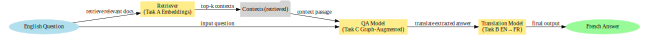

In [ ]:
from graphviz import Digraph
from IPython.display import display

# 1️⃣ SYSTEM PIPELINE GRAPH
dot = Digraph(comment="English→French QA System", format="png")
dot.attr(rankdir="LR", size="9,5", nodesep="0.5", ranksep="0.5")

dot.attr('node', shape='oval', style='filled', color='lightblue2')
dot.node("Q", "🧠 English Question")

dot.attr('node', shape='box', style='filled', color='lightgoldenrod1')
dot.node("R", "Retriever\n(Task A Embeddings)")
dot.node("QA", "QA Model\n(Task C Graph-Augmented)")
dot.node("MT", "Translation Model\n(Task B EN→FR)")

dot.attr('node', shape='folder', style='filled', color='lightgray')
dot.node("C", "Contexts (retrieved)")

dot.attr('node', shape='oval', style='filled', color='palegreen')
dot.node("A", "🇫🇷 French Answer")

dot.edge("Q", "R", label="retrieve relevant docs")
dot.edge("R", "C", label="top-k contexts")
dot.edge("Q", "QA", label="input question")
dot.edge("C", "QA", label="context passage")
dot.edge("QA", "MT", label="translate extracted answer")
dot.edge("MT", "A", label="final output")

display(dot)
